# Web Scraping of Website proving adverts for properties to rent

This notebook presents my webscraping project on a French property website. 
Test

## Table of content
0 - Introduction  
1 - Importing packages, functions, unpickling adverts  
2 - Extracting prices  
3 - Extracting units of objects  
4 - Extracting surface and year of construction  
5 - Extracting non-numeric information from text  


# 0 - Introduction

 ## Importing Packages, Pickle object, Functions
    
    

In [1]:
#Load packages
import pickle5 as pickle
from bs4 import BeautifulSoup
import re
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:

#Load class soup_data
class soup_data:
    '''
    The soup_data is a class object containing the content of one advert scrapped. The attribute contains information  about specific information from the advert. When inititating the class object on the url, the class will make a HTTP request, parse the HTTP with beautiful soup lib.
    @soup: beautiful soup object
    @general:  text  describing the general info of the advert
    @priceblock: text containing different prices related to the advert
    @url: the url of the adv
    @reference: the unique identifier of the advert
    @location: text containing information of the location 
    @date_scrap: the date when the advert was scraped

    '''
    def __init__(self, url):
        headers = {
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
            "Accept-Encoding": "gzip, deflate, br",
            "Accept-Language": "fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7,es;q=0.6",
            "Referer": "https://www.scraperapi.com/",
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.183 Safari/537.36",
        }
        #CLI command to switch VPN server
        os.system("sudo protonvpn c -r")
        #HTTP request
        page = requests.get(url, headers=headers).text
        #Parser with beautiful soup
        soup = BeautifulSoup(page, features='html.parser')

        #Attributes
        self.soup = soup
        self.general = " ".join(self.soup.find(extract_info(soup, section="Général")).parent.parent.strings)
        self.description = " ".join(
            self.soup.find(extract_info(soup, section="L’avis du professionnel")).parent.strings)
        self.priceblock = " ".join(self.soup.find(attrs={"data-test": "price-block"}).strings)
        self.url = url
        self.reference = " ".join(self.soup.find('div', class_="SubHeaderstyled__Reference-sc-1s8qndx-7 sWNHa").strings)
        self.location = " ".join(self.soup.find(id="summary-address").parent.strings)
        self.date_scrape = datetime.today().strftime('%d-%m-%Y')

def extract(param, text):
    '''Function to return a specific number of units (number of bathrooms, rooms) in the soup_data.general
    Parameters:
        param: regex to to find
        text: text to scrap in this instance soup_data.general
    Examples:
    for number of roooms param = "pièce"
    for number of toilets param = "toilette"
    '''
    info = re.search("(\d*,?\d+) ?(?="+param+")", text.lower())
    try:
        return re.sub(",",".",info.group(1))
    except:
        return "NaN"
    
    
def price(param, text):
    '''Function to return a specific fee in the soup_data.priceblock
    Parameters:
        param: regex to find
        text: text to scrap in soup_data.priceblock
        
    Examples:
    for rent param = "le loyer mensuel"
    for deposit param = "dépôt"
    for agency fees param = "à la charge"
    '''
    fees = re.search(param+".+?(\d+,?\d+)",text.lower())
    try:
        return re.sub(",",".",fees.group(1)) #RE to make sure the decimal operator are point.
    except:
        return "NaN"

def specific(param,text):
    '''Function to return True if the word param is in the soup_data.general
    Parameters:
        param: regex to find
        text: text to scrap in soup_data.general
        
    Examples:
    for meublé param = "meublé"
    '''
    info = re.search(param,text)
    return bool(info)

def location(text):
    '''Function that returns the name of the neighbourhood  and the arrondissement in the soup_data.location
        Parameters:
            text: text to scrap in soup_data.location
   
    '''
    match = re.search("quartier\s+(.+)\s+?,.*?(\d+)",text.lower())
    try:
        quartier =  match.group(1)
        arrond = re.sub(",",".",match.group(2))
        return (quartier, float(arrond))
    except:
        return ("NaN", float("NaN"))
               

In [3]:
#Loading the data
with open('Scrap13112020_trial2.pickle', 'rb') as handle:
    master = pickle.load(handle)


AttributeError: Can't get attribute 'Stylesheet' on <module 'bs4.element' from '/Users/jean-charles/opt/anaconda3/lib/python3.7/site-packages/bs4/element.py'>

# 1. Extracting prices

## 1.1 Explanations
I've selected 3 types of prices to be extracted from the adverts: rent, deposit and fees.  To be able to extract these information, we need first to clean the data contained in the "price block" from each advert. In fact, in each advert there was a price block section with all the information related to prices. So in my soup_data object, the priceblock attribute is all the text in the HTML tag associated to the price block.

The two major cleaning I've done are:   
    1. Removing all the spaces in numbers with more than 3 digits: 1 000 -> 1000  
    2. Changing the "," into "." in the prices 
    
To clean my data i've just used regular expressions :). Note that the 2 points has been already introduced in my price function. You can check above!
    

In [4]:
#Removing all the spaces in numbers with more than 3 digits - Example
print("Before: \n{0} \n\nAfter: \n{1}".format(master[186].priceblock,re.sub("(?<=\d) (?=\d+)", "",master[186].priceblock)))

Before: 
Le loyer mensuel est de 1 050 € Charges comprises , dont : - Charges forfaitaires :   100 € Honoraires TTC à la charge du locataire :  475 € dont honoraires TTC réalisation état des lieux :  120 € Dépôt de garantie :  950 € Consulter tous les prix de l'immobilier à Paris 15ème 

After: 
Le loyer mensuel est de 1050 € Charges comprises , dont : - Charges forfaitaires :   100 € Honoraires TTC à la charge du locataire :  475 € dont honoraires TTC réalisation état des lieux :  120 € Dépôt de garantie :  950 € Consulter tous les prix de l'immobilier à Paris 15ème


Now that I've found a way to clean my data, I can extract my data with my function price. Again, I've used regular expressions! Let's see if it's working:

In [5]:
text = re.sub("(?<=\d) (?=\d+)", "",master[186].priceblock)
print("Rent : {0} €".format(price("le loyer mensuel",text)))
print("Deposit : {0} €".format(price("dépôt",text)))
print("Agency fees : {0} €".format(price("à la charge",text)))

Rent : 1050 €
Deposit : 950 €
Agency fees : 475 €


## 1.2 Creating dictionnary with the three features

In [6]:
#Overview of the price contained in the sample scraped
all_prices = {str(pos):float(price("le loyer mensuel", text)) \
              for pos, text in enumerate([re.sub("(?<=\d) (?=\d+)", "",master[i].priceblock) \
                                          for i in range(len(master))])}
price_df = pd.DataFrame(all_prices.values())
print(price_df.describe())

                 0
count   206.000000
mean   1134.873786
std     249.569236
min     480.000000
25%     940.000000
50%    1150.000000
75%    1350.000000
max    1500.000000


In [7]:
#Let's create a dictionnary that will be used to create our dataframe later!
data = {spec:[float(price(spec, text)) \
              for text in [re.sub("(?<=\d) (?=\d+)", "",master[i].priceblock) for i in range(len(master))]] \
              for spec in  ["le loyer mensuel","dépôt","à la charge"]}
df_1 = pd.DataFrame(data)

#Let's rename the columns of our dataframe!
df_1 = df_1.rename(columns = { 'le loyer mensuel' : 'rent', 'dépôt' : 'deposit', 'à la charge' : 'fees'})

#Let's see the head of our dataframe
print(df_1.head())


     rent  deposit    fees
0  1380.0   2628.0  444.00
1  1190.0   2154.0  536.25
2  1150.0      NaN     NaN
3  1240.0   1180.0     NaN
4  1300.0   2280.0     NaN


## 1.3 Plotting our prices as a final check !

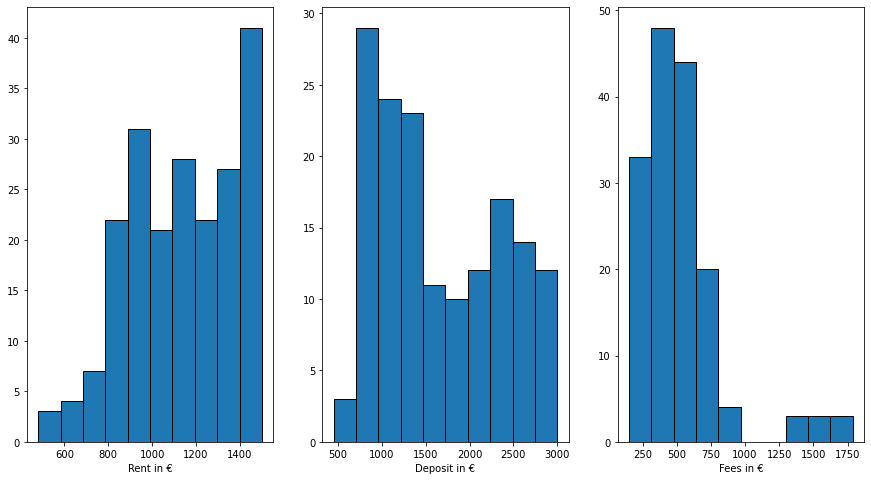

In [22]:
#Let's plot the rent histogram in the 206 ads scraped!
fig, ax = plt.subplots(1,3)

for i in range(df_1.shape[1]):
    ax[i].hist(df_1.iloc[:,i], ec = "black")
    
for i,name in enumerate(["Rent in €", "Deposit in €", "Fees in €"]):
    ax[i].set_xlabel(name)
    
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

# 2. Extracting units of objects

## 2.1 Explanations

The general section of the soup_data object gives general features on the property. Let's expore the longest general text contained in our 206 ads!

In [23]:
#Find longest descritpion
lenchar = [len(text) for text in [master[i].general for i in range(len(master))]]
max_text = np.where(np.array(lenchar) == max(lenchar))[0][0]
master[max_text].general

"Général Surface de 28,2m² Bâtiment de 8 étages 1 Pièce Année de construction 1974 Refait à neuf Au 5ème étage A l'intérieur 1 Salle de bain 1 Salle d'eau 1 Toilette Toilette séparée Parquet Rangements Télévision Chauffage gaz collectif Cuisine américaine équipée Une entrée Autres Interphone Digicode Orientation Ouest Calme Situation : ville Inscrit à l'Ismh"

We can see that that some features are units of objects such as "1 Salle de bain" which means 1 bathroom. With my function extract, I can extract the number of rooms, toiletes, rooms, but also at which floor the floor is located!

## 2.2 Creating a Dataframe 

In [24]:
#Creation of the data fram for specific
data = {spec:[float(extract(spec, text))\
       for text in [master[i].general for i in range(len(master))]] \
       for spec in  ["m²","pièce","toilette","salle de bain","(ème|er) étage", "salle d'eau", "chambre"]}
df_2 = pd.DataFrame(data)
df_2.head()

#Renaming the columns
df_2 = df_2.rename(columns = {"(ème|er) étage":"etage","m²":"surface"})
print(df_2.describe())

          surface       pièce    toilette  salle de bain        etage  \
count  206.000000  206.000000  170.000000           76.0   167.000000   
mean    31.047039    1.519417    1.005882            1.0    14.916168   
std     10.372507    0.564919    0.076696            0.0   146.782661   
min      9.000000    1.000000    1.000000            1.0     1.000000   
25%     23.872500    1.000000    1.000000            1.0     2.000000   
50%     30.035000    1.000000    1.000000            1.0     3.000000   
75%     37.362500    2.000000    1.000000            1.0     5.000000   
max     67.000000    4.000000    2.000000            1.0  1900.000000   

       salle d'eau    chambre  
count        118.0  98.000000  
mean           1.0   1.051020  
std            0.0   0.263695  
min            1.0   1.000000  
25%            1.0   1.000000  
50%            1.0   1.000000  
75%            1.0   1.000000  
max            1.0   3.000000  


All the features look to be in a good shape, with the exception of the étage. Let's find which row corresponds to the 1900 outlier!

In [25]:
#Find row of observation corresponding to a etage == 1900
df_2[df_2["etage"] == 1900]


,surface,pièce,toilette,salle de bain,etage,salle d'eau,chambre
204,37.0,2.0,1.0,1.0,1900.0,NaN,1.0


In [14]:
#Print the corresponding general inscription
print(master[204].general)

Général Surface de 37m² 2 Pièces 1 Chambre Au 1900ème étage A l'intérieur 1 Salle de bain 1 Toilette Toilette séparée Meublé Rangements Télévision Chauffage gaz Cuisine séparée Salle de séjour Autres Digicode Calme


We confirm that the issue comes from the original advert where a typo might have slipped! After checking the advert on the webpage, it should have been 2 instead of 1900. No worries, let's change it!


## 2.3 Plotting our prices as a final check !

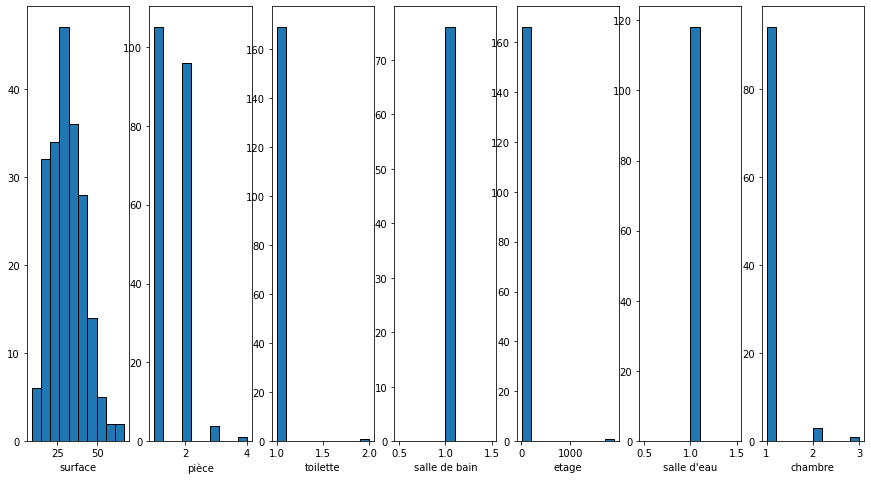

In [26]:
#Let's plot the rent histogram in the 206 ads scraped!
fig, ax = plt.subplots(1,df_2.shape[1])

for i in range(df_2.shape[1]):
    ax[i].hist(df_2.iloc[:,i], ec = "black", bins = 10)
    
for i,name in enumerate(df_2.columns):
    ax[i].set_xlabel(name)
    
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [27]:
#Fonction extraction
print("the number of rooms : {0}".format(extract("pièce",text)))
print("the number of toilettes : {0}".format(extract("toilette",text)))
print("the floor is : {0}".format(extract("(ème|er) étage",text)))

the number of rooms : NaN
the number of toilettes : NaN
the floor is : NaN


# 3 Extracting features Bool / False

## 3.1 Explanations

After extracting  countable units in the general information for each ad, we can now start looking at other features contained in the general description. To have a general idea of the  word frequency in each general description, we will tokenize each ad removing stop words and merging all the words into one.  After counting the words, all the relevant features will appear.  


In [37]:
general = [j.lower() for i in range(len(master)) for j in word_tokenize(master[i].general) if j not in stopwords.words('french') and  j.isalpha()]
vocab = Counter(general)
print(vocab)

Counter({'salle': 300, 'toilette': 222, 'a': 211, 'cuisine': 209, 'général': 206, 'surface': 206, 'au': 167, 'étage': 167, 'autres': 167, 'chauffage': 146, 'meublé': 126, 'digicode': 124, 'une': 109, 'entrée': 109, 'pièce': 105, 'rangements': 102, 'séparée': 101, 'pièces': 101, 'séjour': 100, 'calme': 100, 'bâtiment': 94, 'étages': 94, 'chambre': 94, 'année': 90, 'construction': 90, 'équipée': 85, 'électrique': 78, 'bain': 77, 'individuel': 66, 'parquet': 64, 'interphone': 58, 'américaine': 44, 'orientation': 39, 'refait': 37, 'neuf': 37, 'central': 35, 'coin': 35, 'radiateur': 33, 'télévision': 28, 'situation': 28, 'ville': 28, 'gaz': 22, 'est': 17, 'ouest': 13, 'récent': 13, 'collectif': 9, 'équipé': 8, 'aucune': 7, 'vis': 6, 'manger': 6, 'parking': 5, 'inscrit': 4, 'chambres': 4, 'duplex': 3, 'adapté': 3, 'pmr': 3, 'nord': 3, 'alarme': 2, 'sol': 1, 'mixte': 1, 'toilettes': 1, 'salles': 1})


In [38]:
data = {spec:[specific(spec, text) \
       for text in [master[i].general.lower() for i in range(len(master))]] \
       for spec in  ["meublé","toilette séparée","parquet","rangements", \
                     "télévision","chauffage gaz collectif","chauffage.+électrique" \
                    , "interphone", "digicode", "calme", "alarme","cuisine séparée", "cuisine américaine équipée",
                    "neuf","parking"]}



In [31]:
df_3 = pd.DataFrame(data)
df_3.describe()


,meublé,toilette séparée,parquet,rangements,télévision,chauffage gaz collectif,chauffage.+électrique,interphone,digicode,calme,alarme,cuisine séparée,cuisine américaine équipée,neuf,parking
count,206,206,206,206,206,206,206,206,206,206,206,206,206,206,206
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
freq,126,153,142,104,178,197,128,148,124,106,204,158,181,169,201


# 4. Extracting the Location

In [21]:

data = {spec:[location(text)[i] \
       for text in [master[i].location for i in range(len(master))]] \
       for i,spec in  enumerate(["quartier", "arrond"])}
df_4 = pd.DataFrame(data)

In [22]:
df = pd.concat([df_1,df_4,df_2,df_3], axis = 1)
df

,rent,deposit,fees,quartier,arrond,surface,pièce,toilette,salle de bain,etage,...,chauffage gaz collectif,chauffage.+électrique,interphone,digicode,calme,alarme,cuisine séparée,cuisine américaine équipée,neuf,parking
0,1380.0,2628.0,444.00,louis blanc-aqueduc,10.0,37.00,1.0,1.0,1.0,7.0,...,False,True,False,False,True,False,True,False,False,False
1,1190.0,2154.0,536.25,nation-alexandre dumas,11.0,35.75,1.0,1.0,1.0,8.0,...,True,False,True,False,False,False,True,False,False,False
2,1150.0,NaN,NaN,bel-air nord,12.0,26.00,1.0,1.0,NaN,3.0,...,False,True,False,True,True,False,True,False,False,False
3,1240.0,1180.0,NaN,vallée de fécamp,12.0,28.34,2.0,NaN,1.0,1.0,...,False,True,False,True,False,False,False,False,True,False
4,1300.0,2280.0,NaN,salpêtrière-austerlitz,13.0,41.00,2.0,1.0,NaN,5.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,690.0,NaN,277.80,buttes chaumont,19.0,18.58,1.0,NaN,NaN,NaN,...,False,False,True,True,True,False,False,False,False,False
202,1280.0,1290.0,855.00,télégraphe-pelleport saint fargeau,20.0,57.00,2.0,1.0,1.0,1.0,...,False,False,False,True,True,False,True,False,False,False
203,1185.0,1115.0,558.75,sentier-bonne nouvelle,2.0,37.25,3.0,1.0,NaN,5.0,...,False,True,True,True,False,False,True,False,False,False
204,1350.0,NaN,NaN,gros caillou,7.0,37.00,2.0,1.0,1.0,1900.0,...,False,False,False,True,True,False,True,False,False,False


In [23]:
df.isna().sum() / len(df) * 100

rent                           0.000000
deposit                       24.757282
fees                          23.300971
quartier                       0.000000
arrond                        12.621359
surface                        0.000000
pièce                          0.000000
toilette                      17.475728
salle de bain                 63.106796
etage                         18.932039
salle d'eau                   42.718447
chambre                       52.427184
meublé                         0.000000
toilette séparée               0.000000
parquet                        0.000000
rangements                     0.000000
télévision                     0.000000
chauffage gaz collectif        0.000000
chauffage.+électrique          0.000000
interphone                     0.000000
digicode                       0.000000
calme                          0.000000
alarme                         0.000000
cuisine séparée                0.000000
cuisine américaine équipée     0.000000


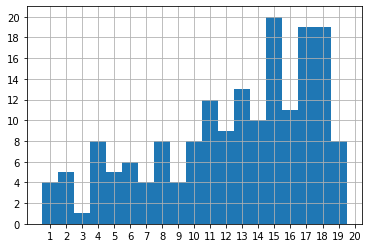

In [42]:
df['arrond'].hist(bins = np.arange(0.5,20))
plt.xticks(np.arange(1,21))
plt.yticks(np.arange(0,21,2))
plt.show()

<AxesSubplot:>

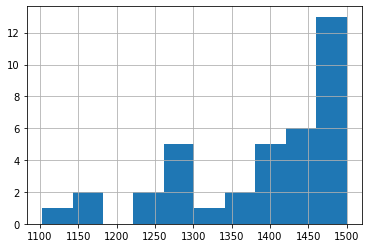

In [41]:
df.loc[df['surface'] > 40, 'rent'].hist()



In [272]:
master[17].location

'Quartier  Sentier-Bonne Nouvelle ,  Paris 2ème'

In [273]:
location(master[17].location)

('sentier-bonne nouvelle', 2.0)

In [274]:
df.iloc[17,:]

rent                                             830
deposit                                         1560
fees                                             240
quartier                      sentier-bonne nouvelle
arrond                                             2
surface                                           16
pièce                                              1
toilette                                           1
salle de bain                                    NaN
etage                                              1
salle d'eau                                        1
chambre                                          NaN
meublé                                          True
toilette séparée                                True
parquet                                        False
rangements                                      True
télévision                                     False
chauffage gaz collectif                        False
chauffage.+électrique                         

In [275]:
df_4

,quartier,arrond
0,louis blanc-aqueduc,10.0
1,nation-alexandre dumas,11.0
2,bel-air nord,12.0
3,vallée de fécamp,12.0
4,salpêtrière-austerlitz,13.0
...,...,...
201,buttes chaumont,19.0
202,télégraphe-pelleport saint fargeau,20.0
203,sentier-bonne nouvelle,2.0
204,gros caillou,7.0


In [34]:
?extract

Signature: extract(param, text)
Docstring:
Function to return a specific number of units (number of bathrooms, rooms) in the soup_data.general
Parameters:
    param: regex to to find
    text: text to scrap in this instance soup_data.general
Examples:
for number of roooms param = "pièce"
for number of toilets param = "toilette"
File:      ~/Documents/Projects/pythonProject/<ipython-input-32-554572315e81>
Type:      function
